<a href="https://colab.research.google.com/github/ParalelaUCM/biciMAD/blob/master/PracticaSpark_BiciMad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Instalamos y configuramos las herramientas necesarias para empezar a trabajar

In [0]:
!apt-get install openjdk-8-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!pip install pyspark

In [0]:
import json
import matplotlib.pyplot as plt
import statistics as stats
from pyspark import SparkContext

In [0]:
!pip install patool

from bs4 import BeautifulSoup
import requests
import zipfile
import patoolib

In [0]:
sc = SparkContext()

# **Descargamos los datasets de biciMAD**
Automatizamos la obtención de los archivos de datos de la web oficial de biciMAD.

La función `descarga` usa los paquetes Beautiful Soup y requests, automatizando la obtención de los archivos. En caso de tenerlos ya a mano, sólo habría que recolocarlos en las carpetas dispuestas.

Los renombraremos a '.zip' o '.rar' para poder descomprimirlos y reubicarlos en la carpeta 'datasets'. Por último eliminamos los ficheros comprimidos.

In [0]:
#Estructura de carpetas para el dataset
!mkdir dataset
!cd dataset/
!mkdir dataset/usages
!mkdir dataset/stations

In [0]:
#datos de páginas web para la descarga de los dataset
pagina = "https://opendata.emtmadrid.es"
url = requests.get("https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)")
html_doc = url.text
soup = BeautifulSoup(html_doc, 'html.parser')
meses_l = [None, "enero","febrero","marzo","abril","mayo","junio","julio",
           "agosto","septiembre","octubre","noviembre","diciembre"]

In [0]:
def descarga(mes,año):
  for link in soup.find_all('a'):
    l = link.get('title')
    if isinstance(l,str):
      if meses_l[mes] in l.lower() and str(año) in l:
        if "uso" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/usages")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/usages")
            os.remove("/content/temp.rar")
        elif "estaciones" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/stations")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/stations")
            os.remove("/content/temp.rar")

In [8]:
#Trabajamos con los datos de 2019
for i in range(1,7):
  descarga(i,2019)

Datos de uso de Enero de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Enero de 2019. Nueva ventana
Datos de uso de Febrero de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Febrero de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content/dataset/stations'
patool: ... temp.rar extracted to `/content/dataset/stations'.
Datos de uso de Marzo de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Marzo de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content/dataset/stations'
patool: ... temp.rar extracted to `/content/dataset/stations'.
Datos de uso de Abril de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Abril de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content

# **Creamos los RDD**
Una vez tenemos las bases de datos descargadas vamos a codificarlas de forma cómoda.

Para tener los datos almacenados de una forma accesible, primero creamos un diccionario cuya clave va a ser un string con el mes y el año del dataset y como valor va a tener el rdd asociado al uso por usuario de ese mes.

La funcion `mapper_usages` nos servirá para crear la rdd más legible. Nos quedaremos con los datos necesarios y cada línea la codificaremos como un diccionario.

In [0]:
rdd_usages = {} 

In [0]:
def mapper_usages(line):
  data = json.loads(line)
  user = data['user_type']
  user_day = data['user_day_code']
  start = data['idunplug_station']
  end = data['idplug_station']
  date = data['unplug_hourTime']['$date'][0:10]
  hora = data['unplug_hourTime']['$date'][11:19]
  time = data['travel_time']
  age = data['ageRange']
  try:
    track = data['track']
  except:
    track = None
  return {"user_type": user,
          "user_day_code": user_day,
          "start": start,
          "end": end,
          "travel_time": time,
          "date": date,
          "hour": hora,
          "age": age,
          "track": track}

In [11]:
directory = 'dataset/usages'
rdd_usages['2019'] = sc.emptyRDD()
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[0]
      rdd_usages[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_usages)
      rdd_usages['2019'] = rdd_usages['2019'].union(rdd_usages[name])
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201904
201901
201902
201906
201905
201903


In [12]:
#Ejemplo de nuestra estructura de datos para los usos
rdd_usages['2019'].take(1)

[{'age': 0,
  'date': '2019-04-01',
  'end': 175,
  'hour': '00:00:00',
  'start': 1,
  'track': None,
  'travel_time': 291,
  'user_day_code': 'c13f2d3716cf96a3655e25967d9b2b08582586cc06f2b7711674b6845f137526',
  'user_type': 1}]

Por otro lado, un diccionario cuya clave va a ser también un string con el mes y el año del dataset y como valor va a tener el rdd asociado a la ocupación de las estaciones en ese mes.

Aquí usaremos la funcion `mapper_stations` para acomodar los datos.

In [0]:
rdd_stations = {}

In [0]:
def mapper_stations(line):
  data = json.loads(line)
  day = data['_id'][0:10]
  hour = data['_id'][11:27]
  station = data['stations']
  return {"day": day, "hour": hour, "station": station}

In [15]:
directory = 'dataset/stations'
rdd_stations['2019'] = sc.emptyRDD()
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[2].split(".")[0]
      rdd_stations[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_stations)
      rdd_stations['2019'] = rdd_stations['2019'].union(rdd_stations[name])
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201903
201904
201902
201906
201901
201905


# **Análisis de los meses disponibles de 2019**
En esta primera parte tratamos los 6 primeros meses de 2019, para tener un abanico de datos más amplio del uso de BiciMad.

### **Analisis y comparativas entre datos nocturnos y diurnos**
De una forma breve, vemos la diferencia entre los datos nocturnos y diurnos, simplemente teniendo en cuenta el número de usuarios.

Lo primero que haremos será ver el número de usuarios diferenciados por tipos según sean horas diurnas o nocturnas.

Tomaremos como 'horas nocturnas' las horas comprendidas entre las 00:00 y las 05:59. Ahora, como en los archivos de bicimad solo se distinguen las horas exactas, nuestras referencias nocturnas serán las 00:00, 01:00, 02:00, 03:00, 04:00 y 05:00.

In [0]:
#Con esta función filtramos los datos de la rdd que sean nocturnos.
def horasNocturnas(data):
  hora_minima = 0
  hora_maxima = 6
  hora_actual = int(data['hour'][:2])
  if hora_minima < hora_maxima:
    return hora_minima <= hora_actual and hora_actual < hora_maxima
  elif hora_minima > hora_maxima:
    return hora_minima <= hora_actual or hora_actual < hora_maxima

In [0]:
rddNocturna = rdd_usages['2019'].filter(lambda x: horasNocturnas(x))

In [18]:
#Separamos ahora por tipo de usuario, para el caso nocturno
night_data = rddNocturna.map(lambda x: x['user_type']).countByValue()
night_data

defaultdict(int, {0: 203, 1: 154927, 2: 1381, 3: 23428})

Creamos una gráfica para ver mejor los datos.

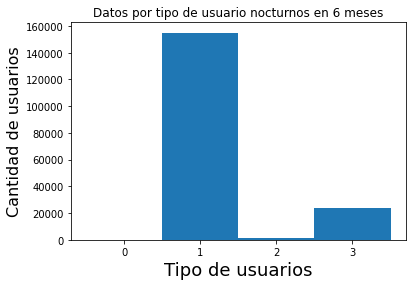

In [19]:
plt.title('Datos por tipo de usuario nocturnos en 6 meses')
names = list(night_data.keys()) 
values = list(night_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Podemos observar cómo la mayoría de usuarios que han usado BiciMAD por la noche son usuarios del tipo 1, es decir, los anuales, mientras que hay muy pocos usuarios ocasionales. 

In [0]:
#Realizamos lo propio para el caso diurno
rddDiurna =  rdd_usages['2019'].filter(lambda x: not(horasNocturnas(x)))

In [21]:
day_data = rddDiurna.map(lambda x: x['user_type']).countByValue()
day_data

defaultdict(int, {0: 1646, 1: 1767639, 2: 25599, 3: 118387})

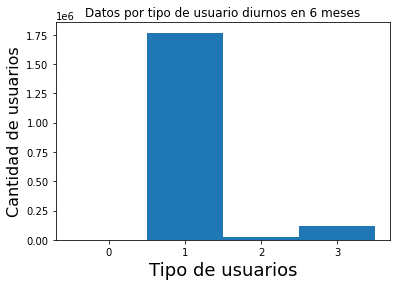

In [22]:
plt.title('Datos por tipo de usuario diurnos en 6 meses')
names = list(day_data.keys()) 
values = list(day_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Los datos de los histogramas son muy parecidos, por lo que para ver la diferencia entre los datos nocturnos y diurnos es necesario hacer una proporción.

In [23]:
#Proporción ocasionales/anuales en los datos nocturnos
print("Proporción 'nocturna' entre tipo 2 sobre tipo 1: ", night_data[2]/night_data[1])

Proporción 'nocturna' entre tipo 2 sobre tipo 1:  0.008913875567202618


In [24]:
#Proporción ocasionales/anuales en los datos diurnos
print("Proporción 'diurna' entre tipo 2 sobre tipo 1: ", day_data[2]/day_data[1])

Proporción 'diurna' entre tipo 2 sobre tipo 1:  0.014482029418902842


Ambas proporciones son muy parecidas y bastante bajas por lo que los usuarios ocasionales no repercuten en gran medida en los datos, ya que principalmente los usuarios de BiciMAD son de tipo anual.

### **Análisis de días laborables y fines de semana**
Cabe pensar que el uso de BiciMAD por la noche se acentúa durante los fines de semana, de ahí este apartado.

Lo primero que necesitamos es una función que nos diferencia entre días laborables y fines de semana. Tomaremos como fin de semana viernes, sábado y domingo.

Utilizaremos la librería `datatime`, para obtener de forma sencilla qué día de la semana es una fecha dada.

In [0]:
from datetime import datetime, date, time, timedelta
import calendar
def cambioFormato(fecha):
  formato1 = "%A" #formatos: https://python-para-impacientes.blogspot.com/2014/02/operaciones-con-fechas-y-horas.html 
                            #https://blog.ipswitch.com/es/formato-de-fecha-en-python 
  dia=datetime.strptime(fecha, '%Y-%m-%d') #El segundo dato es el formato que tiene la fecha que le estoy dando
  dia_1=dia.strftime(formato1)
  return dia_1

In [0]:
def weekend(line, madrugada):
  """
  madrugada es un booleano para decirle si queremos que nos coja los días pero por la noche.
  Por ejemplo, en las horas nocturnas queremos que coja los sábados, los domingos y los lunes.
  """
  if madrugada:
    days=['Saturday', 'Sunday', 'Monday']
  else:
    days=['Friday', 'Saturday', 'Sunday'] 
  #por ejemplo si queremos los datos diurnos, pues lo pondríamos a 'not weekend(fecha, FALSE)'
  dia=cambioFormato(line['date'])
  return dia in days

In [27]:
rddWeekend=rddNocturna.filter(lambda x: weekend(x, True)) #madrugada a True porque estamos usando datos nocturnos.
weekend_data=rddWeekend.map(lambda x: x['user_type']).countByValue()
weekend_data

defaultdict(int, {0: 162, 1: 88006, 2: 954, 3: 8922})

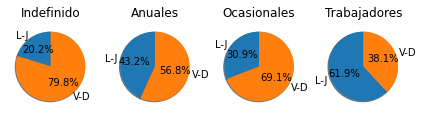

In [28]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data[0]-weekend_data[0], weekend_data[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data[1]-weekend_data[1], weekend_data[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data[2]-weekend_data[2], weekend_data[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data[3]-weekend_data[3], weekend_data[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

Como vemos, más de la mitad de viajeros que tienen pase anual, utilizan BiciMad en el fin de semana. Podemos ver que incluso casi el 70% de los viajes ocasionales se producen durante el fin de semana. Sin embargo, de los trabajadores de la empresa, solo el 38% lo hace en fin de semana.


El porcentaje de los usuarios ocasionales es interesante compararlo con el estudio que habíamos realizado antes. En ese caso no se observaba una diferencia notable de este tipo de usuarios entre las horas nocturnas y las diurnas. Sin embargo, ahora sí que hay una clara diferencia teniendo en cuenta tan solo los días en horas nocturnas. Esto se puede deber a que, como sale más gente joven, hagan uso de BiciMAD para desplazarse.

Veamos ahora, los movimientos por horas.


In [0]:
def movimientosPorHoras(data):
  hora = data['hour']
  user = data['user_type']
  age = data['age']
  return hora, (user, age)

Tomamos los movimientos por horas nocturnos:

In [30]:
time_data=rddNocturna.map(movimientosPorHoras).countByKey()
time_data

defaultdict(int,
            {'00:00:00': 59407,
             '01:00:00': 43304,
             '02:00:00': 31143,
             '03:00:00': 19471,
             '04:00:00': 14793,
             '05:00:00': 11821})

Tomamos los movimientos por horas en fin de semana:

In [31]:
weekend_time_data = rddWeekend.map(movimientosPorHoras).countByKey()
weekend_time_data

defaultdict(int,
            {'00:00:00': 26845,
             '01:00:00': 23227,
             '02:00:00': 18568,
             '03:00:00': 13009,
             '04:00:00': 9402,
             '05:00:00': 6993})

Creamos dos gráficos, uno con los días laborables y otro con los fines de semana.

In [32]:
"""
Para obtener los días laborables, tenemos que 'restar' los datos de los fines de semana a los totales.
"""
laborable_time_data={}
for i in range(0,6):
  laborable_time_data['0'+str(i)+':00:00']=time_data['0'+str(i)+':00:00'] - weekend_time_data['0'+str(i)+':00:00']
laborable_time_data

{'00:00:00': 32562,
 '01:00:00': 20077,
 '02:00:00': 12575,
 '03:00:00': 6462,
 '04:00:00': 5391,
 '05:00:00': 4828}

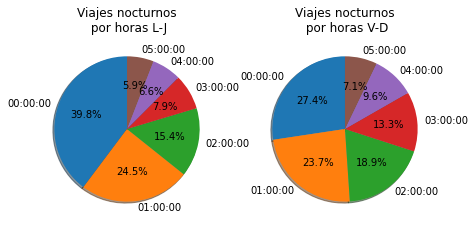

In [33]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(laborable_time_data.values()), labels=list(laborable_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data.values()), labels=list(weekend_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

Como vemos, en los días laborables casi el 65% de los viajes se realiza antes de las 2 de la madrugada, y este porcentaje se reduce al 51% cuando hablamos de los fines de semana, cuando se incrementa el número de viajes a partir de las 2 de la madrugada.

Para entenderlo mejor, veamos también distinciones por horas y usuarios.

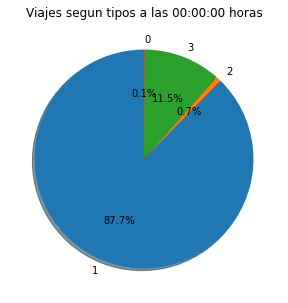

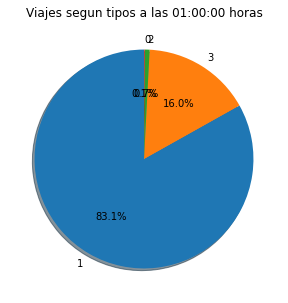

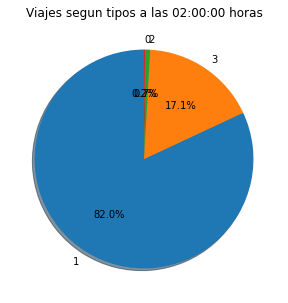

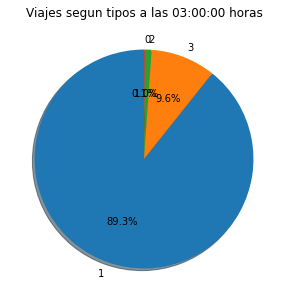

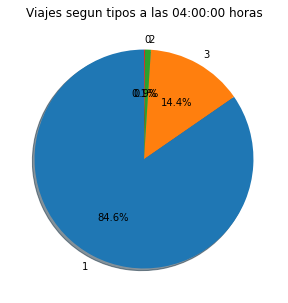

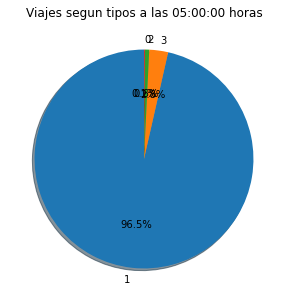

In [34]:
horas = ['00:00:00','01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']
def grafica(dic, value, modo):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes segun '+modo+' a las '+horas[value]+' horas')
  plt.show()

rddHoras=rddNocturna.map(movimientosPorHoras)
for i in range(len(horas)):
  #grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i)
  grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i, 'tipos')
#Tarda un rato y he intentado ponerlo como lo ponia elisa pero quedaba muy pequeño y no se absolutamente nada. Asi se ve mas pero a lo mejor
#ocupa demasiado.

Como ya habíamos visto, la mayoría de los trayectos realizados son de los usuarios de tipo 1, los anuales, pero también hay que tener en cuenta que entre la 1 y las 2 horas, hay más de un 15% de los viajes que son realizados por los trabajadores de la empresa, mientras que a las 12 y a las 3 de la madrugada, no superan el 12%. Otro dato destacable es que a partir de las 5 de la madrugada, casi el 97% de los viajes, son hechos por personas que tienen el abono anual.

### **Análisis por rango de edades**

Breve análisis del uso nocturno de BiciMAD distinguiendo los usuarios por rangos de edades.

[(0, 51330), (1, 1320), (2, 695), (3, 7748), (4, 24374), (5, 12343), (6, 234)]


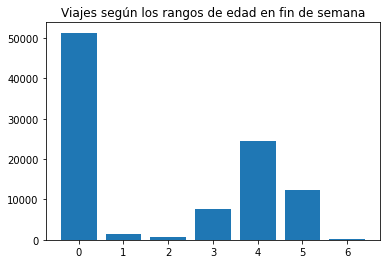

In [35]:
#Empezemos estudiando los usos nocturnos en fines de semana.
"""
Tenemos en cuenta que:
0: no se identifica
1: entre 0 y 16 años
2: entre 17 y 18 años
3: entre 19 y 26 años
4: entre 27 y 40 años
5: entre 41 y 65 años
6: 66 años o más
"""
rddW_ages = rddWeekend.map(lambda x: (x['age'], 1)).countByKey()
print(sorted(rddW_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddW_ages.keys()), list(rddW_ages.values()))
plt.title('Viajes según los rangos de edad en fin de semana')
plt.show()

Aparte de los usuarios no identificados, los que más hacen un uso nocturno los fines de semana son los que están en la franja de edad de entre 27 y 40 años, lo que nos puede indicar que parte de la gente que utiliza bicimad es gente joven. Los usuarios de tipo 1 y 2, a pesar de ser jovenes también, es obvio que haya menos usos en esas edades ya que en las horas en las que estamos comparando no es comun que gente de esas edades este en la calle.

Veamos ahora si este comportamiento es similiar a los días entre semana.

[(0, 42262), (1, 1837), (2, 489), (3, 5698), (4, 19877), (5, 11616), (6, 116)]


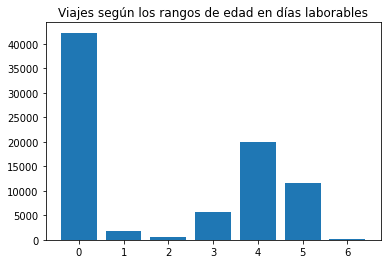

In [36]:
#Partimos de la RDD que tiene los datos filtrados por las horas nocturnas,
#y con poner en filter que no sea fin de semana, tendremos los días laborables.
rddWD_ages = rddNocturna.filter(lambda x: not weekend(x, True)).map(lambda x: (x['age'])).countByValue()
print(sorted(rddWD_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddWD_ages.keys()), list(rddWD_ages.values()))
plt.title('Viajes según los rangos de edad en días laborables')
plt.show()

Aunque ambas gráficas son muy parecidas, pero mirando el numero exacto de datos, se observa un claro aumento de los usurios de tipo 3 y 4 en los fines de semana, que son aquellos cuyas edades están entre 19 y 26 años y entre 27 y 40 años, respectivamente. Podemos suponer por lo tanto, que los usuarios jóvenes y mayores de edad son los que más demanda tienen en horas nocturnas. Además, hay que tener en cuenta que los datos recogidos los fines de semana se establecen en menos días que los datos de diario por lo que el porcentaje de crecimiento es aún mayor. 

Esto está estrechamente relacionado con las gráficas vistas anteriormente en las que se observa claramente cómo hay un mayor uso los fines de semana.


En los datos analizados, estamos teniendo en cuenta aquellos que se obtienen por los trabajadores de la empresa, y como no nos interesan, veamos si hay algún cambio mayor suprimiendo a los trabajadores.

In [37]:
#Eliminamos a los trabajadores de la empresa
rddWD_ages2 = rddNocturna.filter(lambda x: not(weekend(x, True)) and x['user_type'] != 3).map(lambda x: (x['age'])).countByValue()
rddW_ages2 = rddWeekend.filter(lambda x: not(x['user_type'] == 3)).map(lambda x: x['age']).countByValue()
print("Días laborables:", sorted(rddWD_ages2.items(), key=lambda x:x[0]))
print("Fines de semana:", sorted(rddW_ages2.items(), key=lambda x:x[0]))

Días laborables: [(0, 37742), (1, 29), (2, 489), (3, 5698), (4, 15747), (5, 7568), (6, 116)]
Fines de semana: [(0, 48590), (1, 71), (2, 695), (3, 7743), (4, 22304), (5, 9485), (6, 234)]


Los datos son muy parecidos, aunque se observa, como habíamos visto antes, un mayor decrecimiento en los datos diarios ya que hay un mayor uso por parte de los trabajdores.

Otra de las cosas que puede ser interesante analizar distinguiendo por rango de edades, son el uso por horas nocturnas. Una vez más tomaremos los datos sin la aportación de los trabajadores y además, quitaremos los datos también de los usuarios con edad de tipo 0 (no se ha podido distinguir su edad) para una visión más clara.

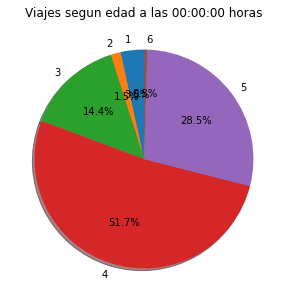

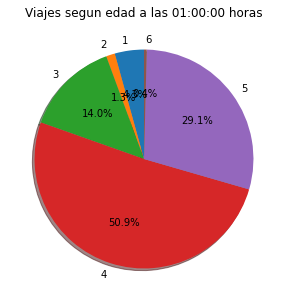

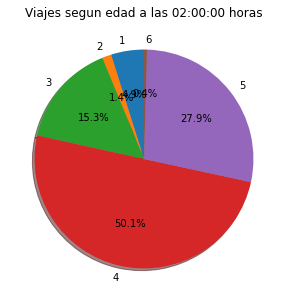

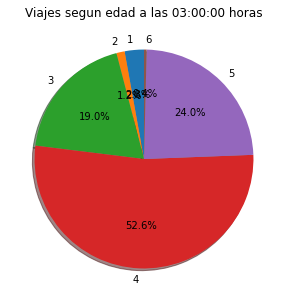

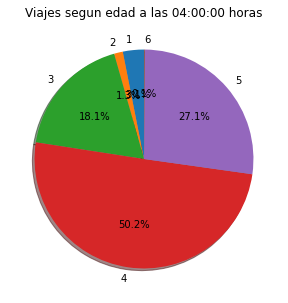

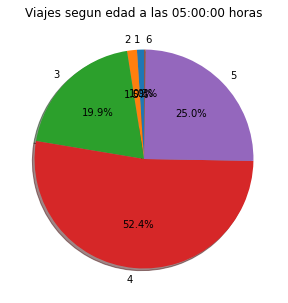

In [38]:
for i in range(len(horas)):
  grafica(rddHoras.filter(lambda x: x[0] == horas[i]).filter(lambda x: x[1][1] != 0).map(lambda x: (x[1][1], 1)).sortByKey().countByKey(), i, 'edad')
  grafica(rddHoras.filter(lambda x: x[0] == horas[i] and x[1][1] != 0).map(lambda x: (x[1][1], 1)).countByKey(), i, 'edad')
  #Creo que tarda mcuho por el sortByKey y despues el countByKey, si lo quitamos tardara menos.

Como podemos ver, no se observa ningún cambio destacable entre las horas. Lo más notorio, quizá sea que los que están en el rango de edad de tipo 1 (menores de 16 años) empiezan a decrecer un poco a partir de las 3 de la madrugada, lo que por otra parte, es lógico.

### **Estaciones más y menos usadas**

Esta sección podríamos haberla incluido en cada una de las anteriores, por ello, haremos un análisis del uso de las estaciones de forma general, parando en cada uno de los puntos anteriores.

In [39]:
#Primero veremos la estación más y menos usada de salida.    
EstMasUsadasStart = rddNocturna.map(lambda x: (x['start'], 1)).reduceByKey(lambda x,y: x+y)\
               .sortBy(lambda x: x[1], False)
print('El ranking de las estaciones más usadas como salida es: ', EstMasUsadasStart.take(10) )
EstMenosUsadasStart = EstMasUsadasStart.sortBy(lambda x: x[1], True)
print('El ranking de las estacione menos usadas como salida es: ', EstMenosUsadasStart.take(10))

El ranking de las estaciones más usadas como salida es:  [(57, 3887), (38, 3105), (175, 2944), (59, 2790), (19, 2748), (129, 2715), (56, 2619), (1, 2603), (6, 2591), (62, 2427)]
El ranking de las estacione menos usadas como salida es:  [(190, 29), (183, 30), (207, 30), (200, 34), (213, 46), (201, 48), (211, 50), (119, 67), (185, 80), (184, 81)]


In [40]:
#Ahora vemos las estación más y menos usadas como destino.
EstMasUsadasEnd = rddNocturna.map(lambda x: (x['end'], 1)).reduceByKey(lambda x,y: x+y)\
               .sortBy(lambda x: x[1], False)
print('El ranking de las estaciones más usadas como destino es: ' ,EstMasUsadasEnd.take(10) )
EstMenosUsadasEnd= EstMasUsadasEnd.sortBy(lambda x: x[1], True)
print('El ranking de las estaciones menos usadas como destino es: ', EstMenosUsadasEnd.take(10) )

El ranking de las estaciones más usadas como destino es:  [(175, 3630), (135, 3585), (129, 3441), (57, 3078), (149, 2898), (83, 2648), (128, 2620), (91, 2497), (132, 2446), (90, 2370)]
El ranking de las estaciones menos usadas como destino es:  [(207, 25), (183, 61), (211, 79), (37, 84), (201, 89), (100, 104), (200, 119), (97, 124), (213, 124), (184, 137)]


¿Hay coincidencias? Veamos si algunas de las estaciones más y menos usadas como salida también son las más y menos usadas como destino.

In [41]:
masUsadas =[]
for i in EstMasUsadasStart.take(10):
  for j in EstMasUsadasEnd.take(10):
    if i[0]==j[0]:
      masUsadas.append(i[0])
print('Las estaciones que coinciden en estar entre las 10 más usadas como salida y destino son: ', masUsadas)
menosUsadas=[]
for i in EstMenosUsadasStart.take(10):
  for j in EstMenosUsadasEnd.take(10):
    if i[0]==j[0]:
      menosUsadas.append(i[0])
print('Las estaciones que coinciden en estar entre las 10 menos usadas como salida y destino son: ', menosUsadas)

Las estaciones que coinciden en estar entre las 10 más usadas como salida y destino son:  [57, 175, 129]
Las estaciones que coinciden en estar entre las 10 menos usadas como salida y destino son:  [183, 207, 200, 213, 201, 211, 184]


Vemos que hay 3 estaciones de entre las 10 más usadas que coinciden como salida y destino y 7 de las menos usadas.
Veamos en qué zona están estas estaciones.

In [0]:
#Creamos una 'base de datos' de las estaciones
def crearDiEst(lista):
  dicEstac={}
  for station in lista:
    dicEstac[station['id']]= {}
    dicEstac[station['id']]['address']=station['address']
  return dicEstac
#Ahora tenemos que 'unir' todos los diccionarios.
listEstacion = rdd_stations['2019'].map(lambda x: crearDiEst(x['station'])).collect()
dicEstaciones = listEstacion[0]
mayor = len(listEstacion[0])
for diccionario in listEstacion:
  dicEstaciones.update(diccionario)

In [43]:
#situación de las estaciones
for estacion in masUsadas+menosUsadas:
  print('La estacion',estacion, 'se encuentra en', dicEstaciones[estacion]['address'])

La estacion 57 se encuentra en Calle Valencia n� 1
La estacion 175 se encuentra en Calle Segovia, 45
La estacion 129 se encuentra en Paseo de Santa Mar�a de la Cabeza n� 58
La estacion 183 se encuentra en Jaime I el Conquistador, 30
La estacion 207 se encuentra en Fernando el Cat�lico, 61
La estacion 200 se encuentra en Avda. Toreros,3
La estacion 213 se encuentra en Navarra, 1
La estacion 201 se encuentra en Avda. Toreros, 49
La estacion 211 se encuentra en General Ampudia, 2
La estacion 184 se encuentra en Alicante, 3


Las tres primeras calles las encontramos cerca de Lavapiés, del Palacio Real y de Madrid Río. Son calles céntricas.

Sin embargo, por ejemplo, la estación 183, que está en la calle de Jaime I el conquistador, está muy cerca de la calle Santa María de la Cabeza, cosa que llama la atención, pues una estación está entre las 10 más usadas, y otra entre las 10 que menos estando a tan solo 800m.
También, en la calle Fernando el Católico, en Moncloa es de las menos usadas, puede ser porque ahí hay otros tipos de transporte más 'cómodos'.
El resto de calles se encuentran tanto en el centro como en las afueras, por lo que tampoco podemos sacar ninguna conclusión clara.

Ahora lo interesante es ver las estaciones más y menos usadas por 'categorías'.

In [44]:
#Laborables y fines de semana (nocturno).
EstMasUsadasLaborable = rddNocturna.filter(lambda x:  not weekend(x, True)).map(lambda x: (x['start'], 1))\
                        .reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], False)
print('El ranking de estaciones más usadas como salida en días laborables es: ' ,EstMasUsadasLaborable.take(10) )
EstMenosUsadasLaborable= EstMasUsadasLaborable.sortBy(lambda x: x[1], True)
print('El ranking de las estaciones menos usadas como salida en días laborables es: ', EstMenosUsadasLaborable.take(10) )

EstMasUsadasWeekend = rddNocturna.filter(lambda x:  weekend(x, True)).map(lambda x: (x['start'], 1))\
                        .reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], False)
print('El ranking de estaciones más usadas como salida en fin de semana es: ' ,EstMasUsadasWeekend.take(10) )
EstMenosUsadasWeekend = EstMasUsadasWeekend.sortBy(lambda x: x[1], True)
print('El ranking de las estaciones menos usadas como salida en fin de semana es: ', EstMenosUsadasWeekend.take(10) )

El ranking de estaciones más usadas como salida en días laborables es:  [(57, 1654), (175, 1517), (38, 1359), (129, 1304), (56, 1272), (135, 1222), (1, 1202), (62, 1156), (19, 1134), (128, 1120)]
El ranking de las estaciones menos usadas como salida en días laborables es:  [(207, 7), (183, 9), (190, 16), (213, 16), (200, 18), (201, 22), (119, 23), (211, 23), (185, 41), (184, 47)]
El ranking de estaciones más usadas como salida en fin de semana es:  [(57, 2233), (38, 1746), (59, 1684), (6, 1628), (19, 1614), (58, 1435), (175, 1427), (129, 1411), (1, 1401), (26, 1365)]
El ranking de las estaciones menos usadas como salida en fin de semana es:  [(190, 13), (200, 16), (183, 21), (207, 23), (201, 26), (211, 27), (213, 30), (184, 34), (185, 39), (119, 44)]


# **Comparativa entre un mes de invierno y un mes de verano**

Como sabemos, cada estación del año modifica ciertos hábitos de las personas, y pensamos que puede ser una de las cosas que afecte al uso nocturno de BiciMad. Para ver las diferencias que se dan, comparamos un mes de invierno (enero) y otro de verano (junio).

### **Analisis y comparativas entre datos nocturnos y diurnos.**

Vamos a analizar los datos observando las diferencias entre diurnos y nocturnos, al igual que hemos realizado anteriormente, en los meses indicados. De igual manera, 
tomaremos como 'horas nocturnas' las horas comprendidas entre las 00:00 y las 05:59 y debido a los datos nuestras referencias nocturnas serán las 00:00, 01:00, 02:00, 03:00, 04:00 y 05:00.
Utilizaremos la función horasNocturnas definida en el apartado anterior.
Lo primero que haremos será ver el número de usuarios diferenciados por tipos según sean horas diurnas o nocturnas.

In [0]:
#separamos el mes de enero y nos centramos en trayectos nocturnos haciendo uso de la función horasNocturnas()
rddNocturnaenero = rdd_usages['201901'].filter(lambda x: horasNocturnas(x))

In [0]:
#separamos de la misma manera que en el paso anterior, este caso el mes de junio
rddNocturnajunio = rdd_usages['201906'].filter(lambda x: horasNocturnas(x))

In [47]:
#aquí realizamos distinciones por tipo de usuario en ambos meses (datos nocturnos)
night_data_enero = rddNocturnaenero.map(lambda x: x['user_type']).countByValue()
night_data_enero

defaultdict(int, {0: 203, 1: 20201, 2: 174, 3: 3418})

In [48]:
night_data_junio = rddNocturnajunio.map(lambda x: x['user_type']).countByValue()
night_data_junio

defaultdict(int, {1: 35485, 2: 353, 3: 4807})

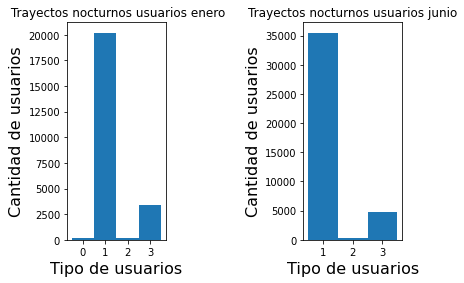

In [49]:
#Creamos ambas tablas a modo de comparativa con los datos nocturnos
names = list(night_data_enero.keys())
values = list(night_data_enero.values())
names1 = list(night_data_junio.keys())
values1 = list(night_data_junio.values())
plt.subplot(131)
plt.title(' Trayectos nocturnos usuarios enero')
plt.bar(names, values, 1)
plt.xticks(names, ["1","2","3","0"])
plt.xlabel('Tipo de usuarios', fontsize=16)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.subplot(133)
plt.title('Trayectos nocturnos usuarios junio')
plt.bar(names1, values1, 1)
plt.xticks(names1, ["1","2","3","0"])
plt.xlabel('Tipo de usuarios', fontsize=16)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()

In [50]:
#obtenemos los datos diurnos de enero por tipo de usuario
rddDiurna_enero = rdd_usages['201901'].filter(lambda x: not(horasNocturnas(x)))
day_data_enero = rddDiurna_enero.map(lambda x: x['user_type']).countByValue()
day_data_enero

defaultdict(int, {0: 1646, 1: 233460, 2: 1793, 3: 18328})

In [51]:
#obtenemos los datos diurnos de junio por tipo de usuario
rddDiurna_junio = rdd_usages['201906'].filter(lambda x: not(horasNocturnas(x)))
day_data_junio = rddDiurna_junio.map(lambda x: x['user_type']).countByValue()
day_data_junio

defaultdict(int, {1: 383274, 2: 5385, 3: 21507})

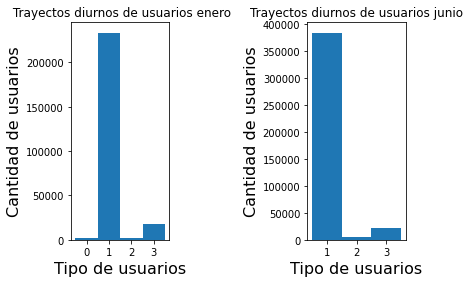

In [52]:
#Creamos ambas tablas a modo de comparativa con los datos diurnos
names = list(day_data_enero.keys())
values = list(day_data_enero.values())
names1 = list(day_data_junio.keys())
values1 = list(day_data_junio.values())
plt.subplot(131)
plt.title(' Trayectos diurnos de usuarios enero')
plt.bar(names, values, 1)
plt.xticks(names, ["1","2","3","0"])
plt.xlabel('Tipo de usuarios', fontsize=16)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.subplot(133)
plt.title('Trayectos diurnos de usuarios junio')
plt.bar(names1, values1, 1)
plt.xticks(names1, ["1","2","3","0"])
plt.xlabel('Tipo de usuarios', fontsize=16)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()

Observando tanto los datos nocturnos como diurnos podemos afirmar que hay un considerable aumento en el uso de la bici 
si comparamos ambos meses. Un dato a tener en cuenta es la desaparición de los usuarios tipo 0 a partir del mes de enero.
Esto puede incrementar el registro en los demás tipos de usuarios y, junto con la mejora de la climatología, la mejora de las infraestructuras y seguridades en los anclajes, y una posible época vacacional, hagan de bicimad un servicio más demandado.


### **Análisis de días laborables y fines de semana**

Analizamos los tipos de datos en ambos meses para ver la evolución del servicio a lo largo de los meses y su utilización en distintas y opuestas estaciones del año. 
Utilizaremos la función cambioFormato, la función weekend y movimientosPorHoras definidas en el estudio de los 6 meses.
Tomaremos como fin de semana viernes, sábado y domingo.

In [53]:
#datos nocturnos en fin de semana en enero y en junio
rddWeekendenero=rddNocturnaenero.filter(lambda x: weekend(x, True)) 
weekend_data_enero=rddWeekendenero.map(lambda x: x['user_type']).countByValue()
weekend_data_enero

defaultdict(int, {0: 162, 1: 10954, 2: 102, 3: 1103})

In [54]:
rddWeekendjunio=rddNocturnajunio.filter(lambda x: weekend(x, True)) 
weekend_data_junio=rddWeekendjunio.map(lambda x: x['user_type']).countByValue()
weekend_data_junio

defaultdict(int, {1: 21693, 2: 252, 3: 2002})

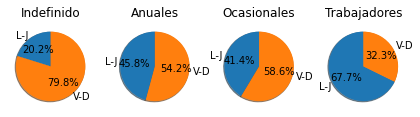

In [55]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data_enero[0]-weekend_data_enero[0], weekend_data_enero[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data_enero[1]-weekend_data_enero[1], weekend_data_enero[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data_enero[2]-weekend_data_enero[2], weekend_data_enero[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data_enero[3]-weekend_data_enero[3], weekend_data_enero[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

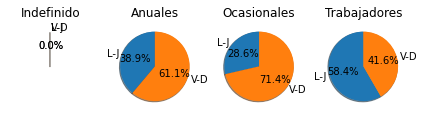

In [56]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data_junio[0]-weekend_data_junio[0], weekend_data_junio[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data_junio[1]-weekend_data_junio[1], weekend_data_junio[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data_junio[2]-weekend_data_junio[2], weekend_data_junio[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data_junio[3]-weekend_data_junio[3], weekend_data_junio[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

Se puede apreciar un incremento en el porcentaje de los trayectos realizados durante los fines de semana en junio respecto a enero en los usuarios de tipo anual y en mayor medida,  de tipo ocasional. Esto puede ser causado por la época vacacional, por las temperaturas o por el aumento de turismo. Debido a esta situación (el agrupamiento de los trayectos durante los fines de semana), se puede suponer también el aumento de los trayectos de los usuarios de tipo 3 para la distribución de las bicis, lo que resulta un cambio significante respecto al mes invernal.


In [57]:
#Separamos los trayectos de los meses por horas a lo largo de la semana
time_data_enero=rddNocturnaenero.map(movimientosPorHoras).countByKey()
time_data_enero

defaultdict(int,
            {'00:00:00': 7432,
             '01:00:00': 5521,
             '02:00:00': 4394,
             '03:00:00': 2612,
             '04:00:00': 2207,
             '05:00:00': 1830})

In [58]:
time_data_junio=rddNocturnajunio.map(movimientosPorHoras).countByKey()
time_data_junio

defaultdict(int,
            {'00:00:00': 13731,
             '01:00:00': 10012,
             '02:00:00': 7097,
             '03:00:00': 4343,
             '04:00:00': 3141,
             '05:00:00': 2321})

In [59]:
#Diferenciamos los trayectos realizados durante el fin de semana
weekend_time_data_enero = rddWeekendenero.map(movimientosPorHoras).countByKey()
weekend_time_data_enero

defaultdict(int,
            {'00:00:00': 2971,
             '01:00:00': 2812,
             '02:00:00': 2453,
             '03:00:00': 1684,
             '04:00:00': 1396,
             '05:00:00': 1005})

In [60]:
weekend_time_data_junio = rddWeekendjunio.map(movimientosPorHoras).countByKey()
weekend_time_data_junio

defaultdict(int,
            {'00:00:00': 6918,
             '01:00:00': 5894,
             '02:00:00': 4518,
             '03:00:00': 3066,
             '04:00:00': 2049,
             '05:00:00': 1502})

In [61]:
#Obtenemos los trayectos en días laborables
laborable_time_data_enero={}
for i in range(0,6):
  laborable_time_data_enero['0'+str(i)+':00:00']=time_data_enero['0'+str(i)+':00:00'] - weekend_time_data_enero['0'+str(i)+':00:00']
laborable_time_data_enero

{'00:00:00': 4461,
 '01:00:00': 2709,
 '02:00:00': 1941,
 '03:00:00': 928,
 '04:00:00': 811,
 '05:00:00': 825}

In [62]:
laborable_time_data_junio={}
for i in range(0,6):
  laborable_time_data_junio['0'+str(i)+':00:00']=time_data_junio['0'+str(i)+':00:00'] - weekend_time_data_junio['0'+str(i)+':00:00']
laborable_time_data_junio

{'00:00:00': 6813,
 '01:00:00': 4118,
 '02:00:00': 2579,
 '03:00:00': 1277,
 '04:00:00': 1092,
 '05:00:00': 819}

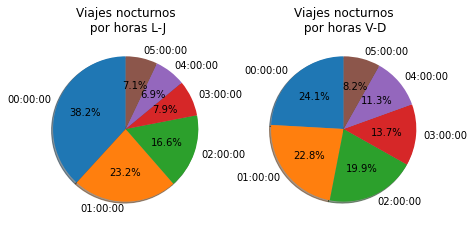

In [63]:
#Creamos dos gráficos, uno con los días laborables y otro con los fines de semana en enero
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(laborable_time_data_enero.values()), labels=list(laborable_time_data_enero.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data_enero.values()), labels=list(weekend_time_data_enero.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

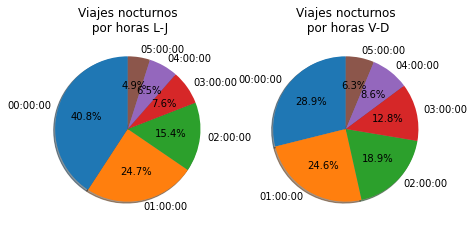

In [64]:
#Creamos dos gráficos, uno con los días laborables y otro con los fines de semana en junio
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(laborable_time_data_junio.values()), labels=list(laborable_time_data_junio.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data_junio.values()), labels=list(weekend_time_data_junio.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

Observamos la tendencia nocturna en ambos meses durante los días no laborables como veíamos en el estudio de los 6 meses.
Los gráficos correspondientes a enero y a junio durante L-J son muy similares.
Como dato curioso y centrándonos en V-D la mayor parte de los desplazamientos en junio se realizan durante las 12 y las 2 mientras que el porcentaje en siguientes horas es superior en enero como no cabría esperar. Dado el aumento de trayectos tempranos en junio, podría ser que debido a que con el buen tiempo la vida de los usuarios es más nocturna y la mayor parte de los movimientos registrados son salidas, mientras que en enero no hay tanto movimiento al ocio. Si bien el número total de movimientos por hora es superior en junio.


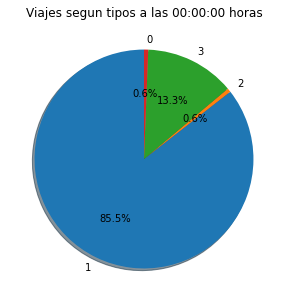

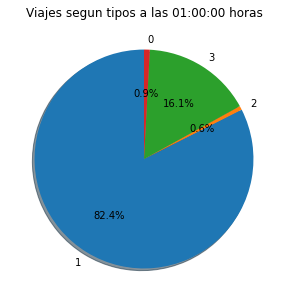

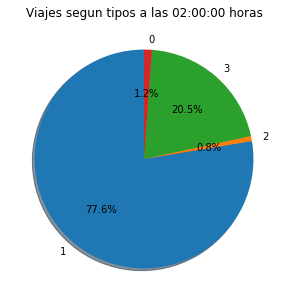

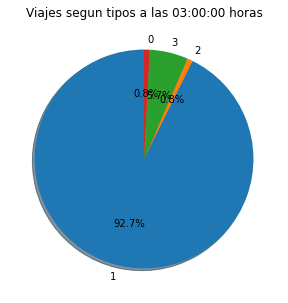

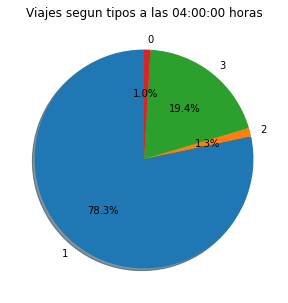

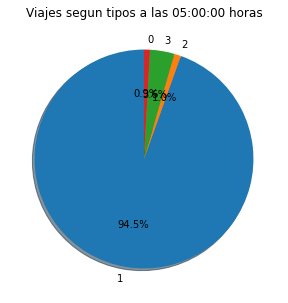

In [65]:
horas = ['00:00:00','01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']

def grafica(dic, value, modo):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes segun '+modo+' a las '+horas[value]+' horas')
  plt.show()

rddHoras_enero=rddNocturnaenero.map(movimientosPorHoras)
for i in range(len(horas)):
  #grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i)
  grafica(rddHoras_enero.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i, 'tipos')

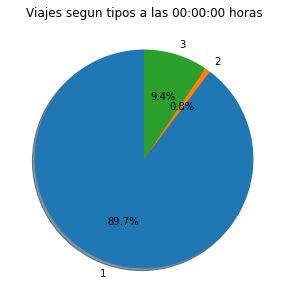

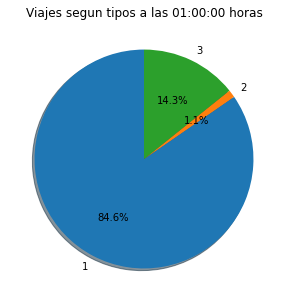

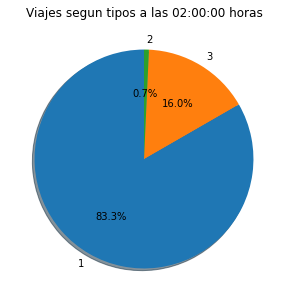

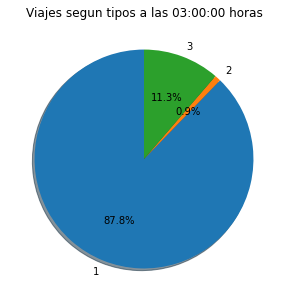

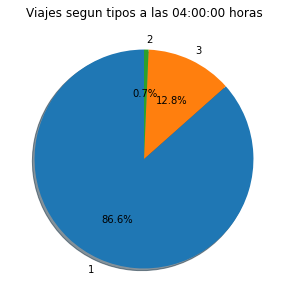

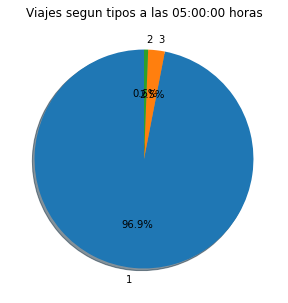

In [66]:
horas = ['00:00:00','01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']
def grafica(dic, value, modo):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes segun '+modo+' a las '+horas[value]+' horas')
  plt.show()

rddHoras_junio=rddNocturnajunio.map(movimientosPorHoras)
for i in range(len(horas)):
  grafica(rddHoras_junio.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i, 'tipos')

Se deduce que en el mes de junio los porcentajes entre usuarios y trabajadores están más equilibrados respecto a los de enero. Se explica porque las diferencias en los porcentajes de los trabajadores entre horas son mucho más destacables en enero, habiendo un 20.5% a las 2h, un 5,7% a las 3h y un 19.4% a las 4h; mientras que en junio los trayectos de trabajadores respecto al número de usuarios están más parejos. Esto puede ser por una redistribución de las horas de trabajo o que debido al aumento de desplazamientos en general en junio provoca una tardanza mayor en los trabajadores y por tanto, cumplimenten todas las horas de la noche.

### **Análisis por rango de edades**

Análisis de los meses centrándonos en el tipo de usuarios por rangos de edad.

In [0]:
#Separamos los tipos de usuarios tanto en enero como en junio
rddW_ages_enero = rddWeekendenero.map(lambda x: (x['age'], 1)).countByKey()
rddW_ages_junio = rddWeekendjunio.map(lambda x: (x['age'], 1)).countByKey()

Viajes según los rangos de edad en fin de semana
[(0, 6190), (1, 133), (2, 110), (3, 1057), (4, 3242), (5, 1566), (6, 23)]


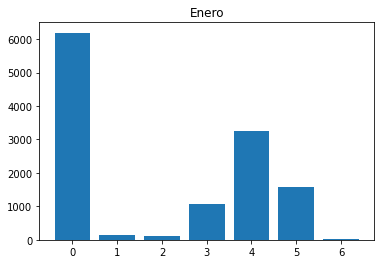

[(0, 12473), (1, 289), (2, 158), (3, 1831), (4, 5744), (5, 3391), (6, 61)]


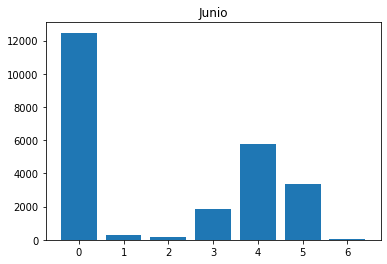

In [68]:
print('Viajes según los rangos de edad en fin de semana')
plt.subplot(111)
rddW_ages_enero = rddWeekendenero.map(lambda x: (x['age'], 1)).countByKey()
print(sorted(rddW_ages_enero.items(), key=lambda x:x[0]))
plt.bar(list(rddW_ages_enero.keys()), list(rddW_ages_enero.values()))
plt.title('Enero')
plt.show()
plt.subplot(111)
rddW_ages_junio = rddWeekendjunio.map(lambda x: (x['age'], 1)).countByKey()
print(sorted(rddW_ages_junio.items(), key=lambda x:x[0]))
plt.bar(list(rddW_ages_junio.keys()), list(rddW_ages_junio.values()))
plt.title('Junio')
plt.show()

Los usuarios que destacan son los tipo 4 en ambos periodos. El incremento de un periodo a otro es notable y destacamos el gran ascenso en los usuarios de tipo 5 y sobre todo de tipo 6 (si bien la cifra sigue siendo baja, casi se ha triplicado) que constituyen usuarios de 41 años en adelante.
Debido a la época del año es posible que el ámbito hostelero tenga una jornada laboral más larga y este grupo, que en su mayoría son trabajadores y clientes, opten por utilizar bicimad en su vuelta a casa.

Viajes según los rangos de edad en días laborables
[(0, 5549), (1, 176), (2, 81), (3, 862), (4, 3040), (5, 1950), (6, 17)]


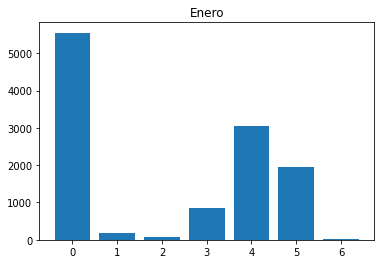

[(0, 8785), (1, 341), (2, 117), (3, 1206), (4, 3766), (5, 2457), (6, 26)]


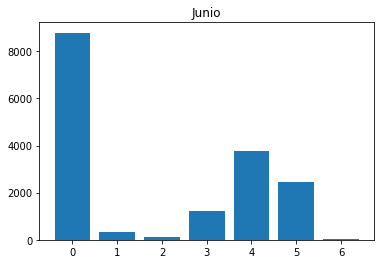

In [69]:
print('Viajes según los rangos de edad en días laborables')
plt.subplot(111)
rddWD_ages_enero = rddNocturnaenero.filter(lambda x: not weekend(x, True)).map(lambda x: (x['age'])).countByValue()
print(sorted(rddWD_ages_enero.items(), key=lambda x:x[0]))
plt.bar(list(rddWD_ages_enero.keys()), list(rddWD_ages_enero.values()))
plt.title('Enero')
plt.show()
plt.subplot(111)
rddWD_ages_junio = rddNocturnajunio.filter(lambda x: not weekend(x, True)).map(lambda x: (x['age'])).countByValue()
print(sorted(rddWD_ages_junio.items(), key=lambda x:x[0]))
plt.bar(list(rddWD_ages_junio.keys()), list(rddWD_ages_junio.values()))
plt.title('Junio')
plt.show()

No existe un cambio tan significativo como en las horas nocturnas. Destacan el aumento en los usuarios de tipo 1. Posiblemente sea por empezar las vacaciones de verano y por la escasez de carga de estudios a partir de mitad del mes.

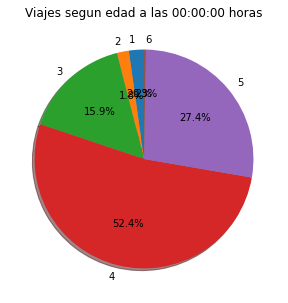

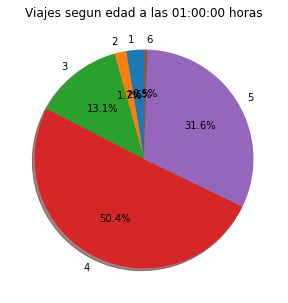

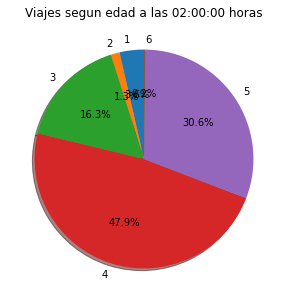

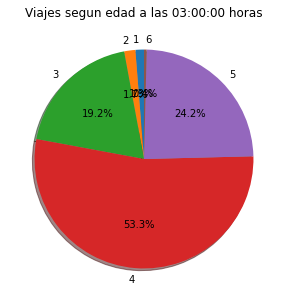

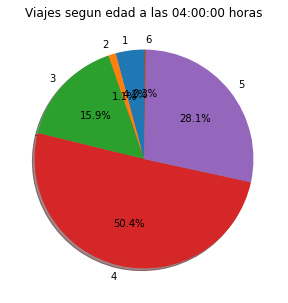

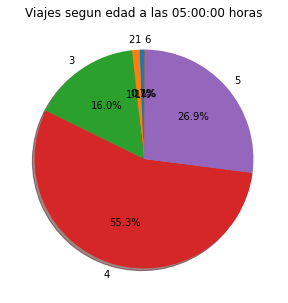

In [70]:
for i in range(len(horas)):
  grafica(rddHoras_enero.filter(lambda x: x[0] == horas[i]).filter(lambda x: x[1][1] != 0).map(lambda x: (x[1][1], 1)).countByKey(), i, 'edad')

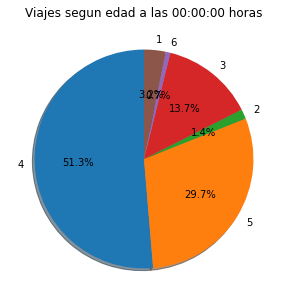

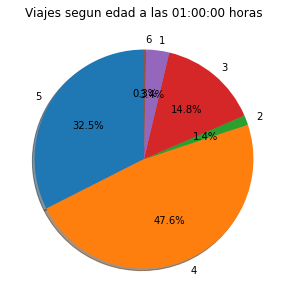

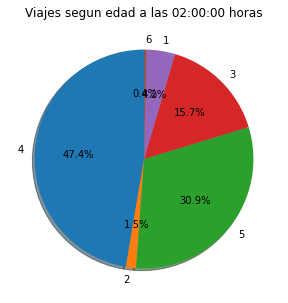

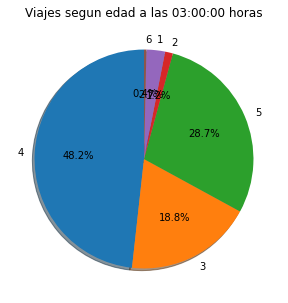

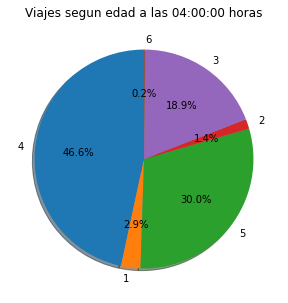

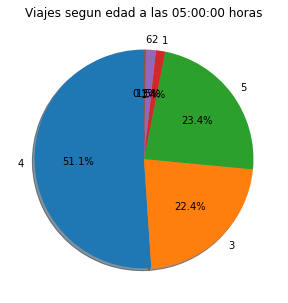

In [117]:
for i in range(len(horas)):
  grafica(rddHoras_junio.filter(lambda x: x[0] == horas[i]).filter(lambda x: x[1][1] != 0).map(lambda x: (x[1][1], 1)).countByKey(), i, 'edad')

Como podemos ver, no se observa ningún cambio destacable entre las horas. Lo único a destacar es que en junio los usuarios de tipo 4 no llegan a alcanzar el 50% hasta las 5 horas mientras que en enero es alcanzado prácticamente toda la noche. Los usuarios jóvenes se mantienen a lo largo de más horas junto con el pequeño aumento antes nombrado de los usuarios tipo 5.

# **Análisis de los trabajadores**
En los apartados anteriores hemos visto que en algunos casos puede afectar más o menos el tipo 'trabajador' a los datos, por lo que analizaremos los datos ajustados al perfil de trabajador para ver qué información nos aporta.

In [0]:
rddTrabajadores = rdd_usages['2019'].filter(lambda x: x['user_type']==3)

In [75]:
num_trabajadores = rddTrabajadores.groupBy(lambda x: x['user_day_code']).count()
print('Hay', num_trabajadores, 'viajes realizados por trabajadores')


Hay 4968 viajes realizados por trabajadores


Para comprobar la afluencia de trabajo distinguiendo por día de diario y fin de semana podemos recurrir al estudio realizado en la parte de la comparativa de los 6 meses en la que, para los trabajadores, se observaba como un 62% lo hacían en los días de diario y tan solo un 38% los fines de semana. Aunque estos datos tan solo representaban las horas nocturnas, la diferencia en los datos se sigue manteniendo pero no la mostramos debido a que es prácticamente idéntica.

Veamos ahora si por horas la distribución cambia.

<BarContainer object of 24 artists>

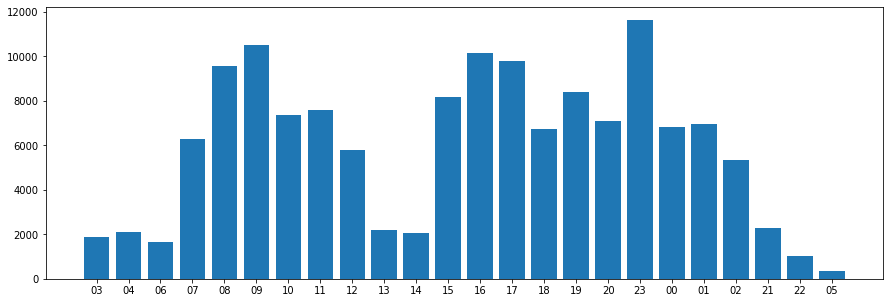

In [76]:
#rddTrabajadores por horas
dicT_horas = rddTrabajadores.map(lambda x: (x['hour'][0:2], 1)).countByKey()
plt.figure(figsize=(15,5))
plt.bar(dicT_horas.keys(), dicT_horas.values())

Podemos observar cómo en las horas nocturnas hay más trabajadores a las 00, la 1 y las 2, que son las horas en las que hay una mayor afluencia de usuarios, como hemos observado anteriormente.

También hay picos de trabajadores en las primeras horas de la mañana y a partir de las 15 horas, que se corresponden con la entrada y salida diaria del horario laboral. 

### **Diferencias entre los tipos de trabajo** 

Analizaremos los diferentes trabajos que realizan, traslados, reparaciones... Por útlimo comprobaremos aquellas estaciones en las que se reponen más bicis y si estas están relacionadas con las que tienen más demanda por parte de los usuarios.

In [0]:
def reparacion(data):
  #se trata de una reparación en la misma estación
  start = data['start']
  end = data['end']
  return start==end
def traslado(data):
  #se trata de un traslado para equilibrar las estaciones
  start = data['start']
  end = data['end']
  return start!=end

Comprobemos ahora qué número de bicicletas tienen que ser reparadas y cuáles tan solo son comprobadas. Para ello, como filtro usaremos que aquellas comprobaciones que se han necesitado más de 1 minuto serán consideradas como una reparación por parte del trabajador

In [0]:
limite=61
comprobada = rddTrabajadores.filter(lambda x: reparacion(x) and x['travel_time']<limite).count()
reparada = rddTrabajadores.filter(lambda x: reparacion(x) and x['travel_time']>=limite).count()

Proporción de reparaciones rápidas 95.08 %


<BarContainer object of 2 artists>

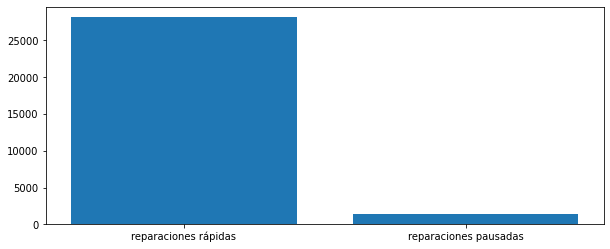

In [79]:
print('Proporción de reparaciones rápidas', "{0:.2f}".format(100*comprobada/(reparada+comprobada)),'%') #proporción del 95% de reparaciones rápidas
plt.figure(figsize=(10,4))
plt.bar(("reparaciones rápidas","reparaciones pausadas"),(comprobada,reparada))

El 95% de las bicis no recibe una reparación pausada por lo que se puede ver cómo los usuarios hacen un buen uso de las bicicletas de BiciMAD. Así los trabajadores podrán centrarse tan solo en reorganizar las bicicletas para mantener el equilibrio en las estaciones.

In [80]:
#nos quedamos con los traslados
rddTraslado = rddTrabajadores.filter(traslado)
traslados = rddTraslado.count()
traslados

112207

<BarContainer object of 2 artists>

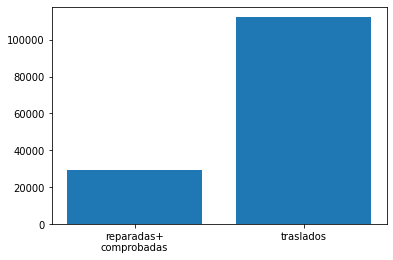

In [81]:
#Veamos ahora en un gráfico la comparación 
plt.figure(figsize=(6,4))
plt.bar(("reparadas+\ncomprobadas","traslados"),(comprobada+reparada, traslados))

El gráfico nos muestra cómo la mayoría de movimientos que realizan los trabajadores son traslados de bicicletas entre estaciones, por lo que será interesante analizar más adelante cómo son estos trayectos.

Veamos ahora si los traslados se realizan a las estaciones más usadas, calculadas en el apartado anterior.
También es interesante comprobar si las estaciones que son menos usadas son de las que se trasladan las bicicletas a aquellas estaciones que tienen una mayor demanda

In [82]:
lisTrasl = rddTraslado.map(lambda x: (x['end'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False).take(10)
print("Las estaciones en las que se reponen más bicicletas son:")
print(lisTrasl)
#El resultado es de la forma: (estacion, nº de repeticiones)

Las estaciones en las que se reponen más bicicletas son:
[(162, 3038), (91, 2933), (154, 2295), (108, 2143), (109, 2141), (139, 1906), (102, 1890), (83, 1849), (167, 1812), (129, 1777)]


Si comparamos las estaciones más usadas como salida   (vista anteriormente) con la lista de las estaciones donde se reponen más bicicletas, difieren en la gran mayoría de estaciones. Esto se debe a que algunas de las estaciones más usadas también son de las estaciones más utilizadas como llegada por lo que son los propios usuarios son los que realizan el equilibrio de las bicicletas.


Si comparamos ahora con las estaciones que eran menos usadas como estaciones de destino, podemos ver igualmente que no estan muy relacionadas por lo que podemos pensar que estas estaciones estan equilibradas por los propios usuarios y los trabajdores reponen en aquellas estaciones que lo necesitan pero sin que estas tengan un cierto patron de uso

Ahora veremos relaciones con aquellas estaciones en las que sobran bicicletas, es decir, aquellas estaciones que son el origen de los traslados realziados por los trabajadores

In [83]:
listTraslOri = rddTraslado.map(lambda x: (x['start'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False).take(10)
print("Las estaciones en las que se reponen más bicicletas son:")
print(listTraslOri)
#El resultado es de la forma: (estacion, nº de repeticiones)

Las estaciones en las que se reponen más bicicletas son:
[(135, 6402), (129, 6190), (132, 4750), (162, 3603), (82, 3597), (133, 3424), (175, 3359), (83, 3283), (128, 3107), (43, 2850)]


Con estos datos las conclusiones a las que podemos llegar son identicas a las anteriores ya que no podemos identificar que estas estaciones de las que parten los traslados de las bicicletas tengan relación con las estaciones más usadas como destino (vistos anteriormente).



NOTA PARA MI (ELISA), FALTA COMENTAR ESTO Y MIRAR LAS ESTACIONES MENOS USADAS. uN VEZ HECHO, COMPROBAR SI LAS BICIS SE MUEVEN DE LAS MENOS USADAS A LAS MÁS USADAS. Esto ya lo he visto yo pero dejo aqui el comentario por si puede faltar algo, pero yo creo que con eso podria ir bien

# **Asesor de ruta biciMAD**
Dada una estación de origen, una de destino y una hora del trayecto, calcularemos el tiempo medio necesitado realizar el trayecto, cuántas bicicletas suele haber disponibles en las estaciones, y si suele haber hueco en la estación final para poder colocar la bicicleta.

In [84]:
#inputs

origen = input('Estación de la que se desea partir: ') #57
destino = input('Estación a la que se desea llegar: ') #38
hora_Viaje = int(input('Hora a la que se desea realizar el viaje(HH): ')) #03


Estación de la que se desea partir: 57
Estación a la que se desea llegar: 38
Hora a la que se desea realizar el viaje(HH): 3


In [0]:
origen = '57' #string
destino = '38' #string
hora_Viaje = int('03') #int

In [0]:
#Función que se queda con los viajes alrededor de la hora solicitada
def rangoTiempo(hora, rango, hora_target):
    hora = hora.split(":")
    h = int(hora[0])
    m = int(hora[1])
    hora = h + m/60.0
    if (hora_target - rango < 0):
      return((hora < hora_target + rango) or 24 + hora_target - rango < hora)
    else:
      return(hora_target - rango < hora and hora < hora_target + rango)

In [0]:
#Primer filtro: nos quedamos con los trayectos que parten de 
#la estación origen y terminan en la estación destino
rdd_trayecto = rdd_usages['2019'].filter(lambda x: x['start'] == int(origen) and x['end'] == int(destino))

In [88]:
print('Total de viajes similares al del cliente sin tener en cuenta el horario: ', rdd_trayecto.count())

Total de viajes similares al del cliente sin tener en cuenta el horario:  690


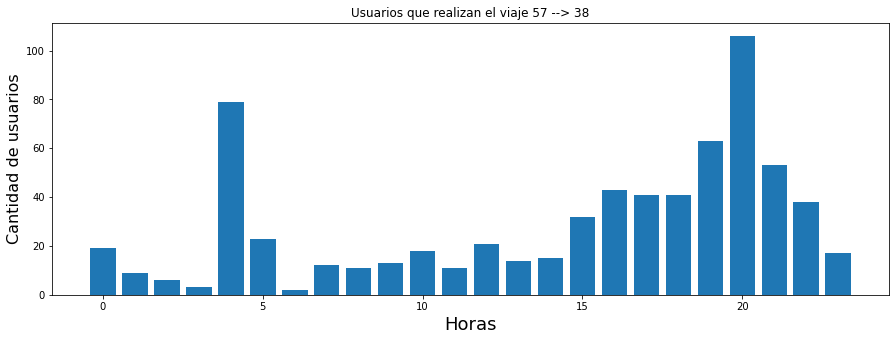

In [89]:
#Veamos cuáles son las horas más comunes para realizar este tipo de viaje.
dicc = rdd_trayecto.map(lambda x: (int(x['hour'][0:2]), 1)).countByKey()
dicc_list = sorted(dicc.keys())
plt.figure(figsize=(15,5))
plt.title("Usuarios que realizan el viaje "+origen+ " --> "+destino)
plt.bar(dicc.keys(), dicc.values())
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()

In [0]:
#Y ahora filtramos ya solo en el rango de horas especificado. 
#En este caso, 1 hora alrededor de la hora elegida.
rdd_viaje = rdd_trayecto.filter(lambda x: rangoTiempo(x['hour'], 1.01, hora_Viaje))

In [91]:
print('Total de viajes similares al del cliente alrededor de la hora especificada: ', rdd_viaje.count())

Total de viajes similares al del cliente alrededor de la hora especificada:  88


In [92]:
def prititime(segundos):
  m = int(segundos // 60)
  s = int(segundos % 60)
  return "{0} minutos y {1} segundos".format(m,s)

#Estudiemos ahora las medias en tiempo de todos los viajes similares a esa hora
listaTiempos = rdd_viaje.map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
media_tiempo_viaje = stats.mean(listaTiempos)
print('La media de tiempo empleado por otros usuarios es',prititime(media_tiempo_viaje))

La media de tiempo empleado por otros usuarios es 6 minutos y 37 segundos


Es importante que el cliente sepa cuántas bicicletas suele haber disponibles en la estación de partida alrededor de la hora en la que tiene pensado realizar su viaje y cuántos sitios habrá disponibles en la estación de llegada. Por ello necesitamos trabajar ahora con los datos que se encuentran en los ficheros de datos sobre las situaciones de las estaciones, los cuales los habiamos almacenado en el diccionario `rdd_stations`.



In [0]:
def estaciones(lista):
  filtro = []
  for estacion in lista['station']:
    if estacion['id'] == int(origen) or estacion['id'] == int(destino):
      filtro.append(estacion)
  return {"day":lista['day'],
          "hour":lista['hour'],
          "station":filtro}

#rdd_Sit_fil contiene solo los datos de las dos estaciones, la de partida y la de llegada
rdd_Sit_fil = rdd_stations['2019'].map(estaciones)

In [0]:
def calcularBasesLibres(lista, n_estacion):
  #Bases libres en la estacion n_estacion
  for station in lista:
    if station['id'] == n_estacion:
      return station['free_bases']

def calcularBicisLibres(lista, n_estacion):
  """
  Bicicletas libres en la n_estacion. Este numero esta formado por el numero de bicicletas en la estación
  menos las bicicletas que ya estan reservadas por otros usuarios y menos aquellas que no esten disponibles.
  """
  for station in lista:
    if station['id'] == n_estacion:
      return station['dock_bikes'] - station['reservations_count'] - station['no_available']

bicisLibres = rdd_Sit_fil.filter(lambda x: rangoTiempo(x['hour'], 1, hora_Viaje))\
              .map(lambda x: [calcularBicisLibres(x['station'], int(origen))]).reduce(lambda a, b: a+b)
basesLibres = rdd_Sit_fil.filter(lambda x: rangoTiempo(x['hour'], 1, media_tiempo_viaje / 3600.0))\
              .map(lambda x: [calcularBasesLibres(x['station'], int(destino))]).reduce(lambda a, b: a+b)

In [95]:
totalBasesPorEstacion = {}
stationsLst = rdd_Sit_fil.take(1)[0]['station']
totalBasesPorEstacion[stationsLst[0]['id']] = stationsLst[0]['total_bases']
totalBasesPorEstacion[stationsLst[1]['id']] = stationsLst[1]['total_bases']

print('La media de bicicletas libres en', origen, 'respecto a la hora elegida es:',int(stats.mean(bicisLibres)), '/', totalBasesPorEstacion[int(origen)])
print('La media de bases libres en', destino ,'respecto a la hora estimada de llegada es:',int(stats.mean(basesLibres)), '/', totalBasesPorEstacion[int(destino)])

La media de bicicletas libres en 57 respecto a la hora elegida es: 15 / 24
La media de bases libres en 38 respecto a la hora estimada de llegada es: 6 / 24


En caso de no tener claro el trayecto para llegar al destino, le indicaremos al cliente qué calles han sido las más transitadas realizando el viaje que se desea hacer. En este caso, no indicaremos al cliente tan solo la calle más utilizada por el resto de usuarios, ya que esta puede ser una calle cualquiera y no servirle de mucha utilidad para planificar su ruta. Le indicaremos cuál ha sido la primera calle más transitada, es decir, la primera calle que han usado los usuarios para realizar el viaje, y la última calle más transitada, es decir, la última calle por la que han pasado antes de llegar al destino. Aunque los datos sobre los trayectos, para que sean anónimos son datos en tiempos aletorios, en general, no son intervalos de tiempo muy grandes por lo que la información de estos trayectos podrá ser útil para planificar una ruta.


In [0]:
#Tan solo estudiaremos los trayectos nocturnos para este caso ya que es lo que nos interesa.

def obtenerCalles(line):
  listaCalles = []
  data = line['track']
  for value in data['features']:
    try:
      calle = value['properties']['var'].split(",")
      listaCalles.append(calle[4])
    except:
      None
  if len(listaCalles) > 0:
    return (listaCalles[-1], listaCalles[0]) #Porque el primer dato es el último que se recibe (de ahí el -1).

rdd_calles = rdd_viaje.filter(horasNocturnas).filter(lambda x: x['user_type'] != 3 and x['track'] != None)\
             .map(obtenerCalles).filter(lambda x: x != None)


In [97]:
"""
Veamos por un lado la primera calle más transitada para realizar el viaje y después la última que más
se ha transtidado a la hora de realizar el viaje 
"""
def eliminarNumero(line):
  data = line.split(" ")
  try:
    entero = int(data[-1])
    modulo = len(data[-1])+1
    return line[:-modulo]
  except:
    return line

calleInicial = rdd_calles.map(lambda x: (eliminarNumero(x[0]), 1)).reduceByKey(lambda x, y: x+y)\
                         .sortBy(lambda x: x[1], False).first()

calleFinal = rdd_calles.map(lambda x: (eliminarNumero(x[1]), 1)).reduceByKey(lambda x, y: x+y)\
                       .sortBy(lambda x: x[1], False).first()

print("La primera calle más usada es: ", calleInicial[0])
print("La última calle más usada es: ", calleFinal[0])


La primera calle más usada es:  CALLE AVE MARIA
La última calle más usada es:  PLAZA JACINTO BENAVENTE


# **Ciclos**
A raíz del estudio de los trabajadores, nos interesa por último ver el aspecto de los ciclos de trayectos, pues pensamos que el protocolo de trabajo de mantenimiento con las bicis puede incluirlos.

In [0]:
#rddprima da el formato (('usuario','tipo'),[lista de [partida,llegada]])
rddprima = rdd_usages['2019'].map(lambda x: ((x['user_day_code'],x['user_type']),[x['start'],x['end']]))\
                              .groupByKey().map(lambda x: (x[0],list(x[1])))

`adic` pasa la lista de pares [partida,llegada] en un diccionario con claves las estaciones de partida y valores la lista de estaciones de llegada

In [0]:
def adic(ldl):
  d = {}
  for elem in ldl:
    key,value = str(elem[0]),str(elem[1])
    if key in d:
      d[key].append(value)
    else:
      d[key]=[value]
  return d

`unomas` actualiza el diccionario con un trayecto entre estaciones comprobando si ese paso resulta en un ciclo o no

In [0]:
separador = "_"
def unomas(dic):
  dic2 = {}
  dk = list(dic.keys())
  for key in dk:
    if not isinstance(key, tuple): #todavía no es un ciclo
      for elem in dic[key]:    
        if key==elem:
          dic2[tuple(set([key]))]=1 #indica ciclo longitud 1
        else:
          spl = key.split(separador)
          if elem in spl:
            pos = spl.index(elem)
            lis = spl[pos:]
            dic2[tuple(set(lis))] = len(spl)-pos #integer indica ciclo
          else:
            try:
              dic2[key+separador+elem]=dic[elem]
            except KeyError:
              pass
  dic2.update(dic)
  return dic2

`sigue` llama recursivamente a `unomas` para recorrer el grafo del usuario en profundidad hasta que se obtiene todos los trayectos posibles

In [0]:
def sigue(dic):
  if len(dic) == len(unomas(dic)):
    return dic
  else:
    return (sigue(unomas(dic)))

`tieneciclos` es un filtro booleano que indica si el usuario ha realizado algún ciclo en ese día

In [0]:
def tieneciclos(dic):
  resultado = False
  for key,value in dic.items():
    if isinstance(key,tuple):
      resultado = True
  return resultado

`dameciclos` se queda con las entradas del diccionario que señalan los ciclos, con clave ahora la longitud

In [0]:
def dameciclos(dic):
  dic2 = {}
  for key,value in dic.items():
    if isinstance(key,tuple):
      try:
        dic2[value].append(key)
      except:
        dic2[value]=[key]
  return dic2

In [0]:
#elimina los ciclos duplicados: al tratar las rdds a veces no consigue
#obtener la misma tupla del ciclo como clave, igual sale desordenada
#y considera que es otro ciclo distinto, teniendo la misma longitud y las mismas
#estaciones, por eso aquí eliminamos los duplicados
def eliminadup(dic):
  daux = {}
  for key,val in dic.items():
    for elem in val:
      try:
        if set(elem) in daux[key]:
          pass
        else:
          daux[key].append(set(elem))
      except:
        daux[key]=[set(elem)]
  dic2 = {}
  for key in daux.keys():
    dic2[key]=[]
    for val in daux[key]:
      dic2[key].append(tuple(val))
  return dic2

`rdd_ciclos` tiene, para cada usuario, los ciclos que ha hecho en un diccionario cuyas claves son las longitudes de los ciclos

In [0]:
rdd_ciclos = rddprima.mapValues(lambda x: adic(x)).mapValues(lambda x: sigue(x))\
          .filter(lambda x: len(x[1])>0).filter(lambda x: tieneciclos(x[1]))\
          .mapValues(lambda x:dameciclos(x)).mapValues(lambda x:eliminadup(x))

In [106]:
#Ejemplos con la rdd_ciclos
rdd_ciclos.filter(lambda x: len(x[1])>1).take(2)

[(('aa71c1d774247c1a4cdbbc3615584c9d1e159c54c8b0e8a102a09ac39dd5a708', 1),
  {1: [('26',), ('123',)], 2: [('45', '26')]}),
 (('b5df0e63dfeede09c9ebd1414dbfa0d03d4340792fa76a357adf78bbdf4716b1', 1),
  {1: [('57',)], 2: [('112', '57')]})]

In [118]:
print("GENERAL")
for i in range(1,11):
    aux = rdd_ciclos.filter(lambda x: i in x[1].keys()).mapValues(lambda x: x[i])
    print("Numero de usuarios que realizan ciclos de longitud",i,":",aux.count())

GENERAL
Numero de usuarios que realizan ciclos de longitud 1 : 42368
Numero de usuarios que realizan ciclos de longitud 2 : 161489
Numero de usuarios que realizan ciclos de longitud 3 : 10595
Numero de usuarios que realizan ciclos de longitud 4 : 1161
Numero de usuarios que realizan ciclos de longitud 5 : 202
Numero de usuarios que realizan ciclos de longitud 6 : 58
Numero de usuarios que realizan ciclos de longitud 7 : 20
Numero de usuarios que realizan ciclos de longitud 8 : 8
Numero de usuarios que realizan ciclos de longitud 9 : 2
Numero de usuarios que realizan ciclos de longitud 10 : 2


In [108]:
print("TRABAJADORES")
for i in range(1,11):
    aux = rdd_ciclos.filter(lambda x: x[0][1]==3).filter(lambda x: i in x[1].keys()).mapValues(lambda x: x[i])
    print("ciclos de longitud",i,":",aux.count())

TRABAJADORES
ciclos de longitud 1 : 3305
ciclos de longitud 2 : 62
ciclos de longitud 3 : 10
ciclos de longitud 4 : 3
ciclos de longitud 5 : 3
ciclos de longitud 6 : 0
ciclos de longitud 7 : 2
ciclos de longitud 8 : 1
ciclos de longitud 9 : 0
ciclos de longitud 10 : 0


`rdd_triciclos` se queda con los ciclos de longitud 3, que son los más comunes sin contar los de ida y vuelta (o return trips)

In [0]:
rdd_triciclos = rdd_ciclos.filter(lambda x: 3 in x[1].keys()).mapValues(lambda x: x[3])

`espia` permite obtener los viajes y ciclos de un usuario concreto

In [0]:
def espia(usu):
  aux = rddprima.filter(lambda x: x[0][0]==usu).collect()
  print("usuario de tipo",aux[0][0][1])
  print("\ntrayectos:")
  print(aux[0][1])
  print("\nciclos:")
  print(rdd_ciclos.filter(lambda x: x[0][0]==usu).collect()[0][1])

In [111]:
usu = '38a62ad6add589ae13017a6f886fd3216fc0a64d1cc27def56eaf81db5c9c885'
espia(usu)

usuario de tipo 1

trayectos:
[[58, 58], [58, 163], [163, 168], [168, 115], [115, 6], [6, 58], [58, 130], [130, 58]]

ciclos:
{5: [('58', '168', '115', '6', '163')], 1: [('58',)], 2: [('130', '58')]}


`triciclorden` recibe un triciclo como tupla y lo devuelve como string de las estaciones ordenadas crecientemente separadas por cierto separador predefinido

In [0]:
from functools import reduce as functools_reduce
def triciclorden(tupla):
  aux = [str(eleme) for eleme in sorted([int(elem) for elem in tupla])]
  return functools_reduce(lambda a,b:a+separador+b, aux)

`rdd_3` tiene los triciclos con las estaciones ordenadas como clave y el número de veces que se repite el triciclo como valor

Nota: con `flatMapValues` obtenemos los triciclos por separado de aquellos ususarios que han realizado más de un triciclo al día

In [0]:
rdd_3 = rdd_triciclos.flatMapValues(lambda x: x).mapValues(lambda x: triciclorden(x))\
                      .map(lambda x: (x[1],1)).groupByKey().mapValues(sum)

In [114]:
rdd_3.count() #número total de triciclos realizados

8701

In [115]:
#Los triciclos realizados más veces
rdd_3.sortBy(lambda x: x[1], False).take(10)

[('20_36_58', 26),
 ('101_130_162', 26),
 ('136_146_162', 17),
 ('30_129_163', 16),
 ('30_63_132', 15),
 ('48_83_119', 15),
 ('78_87_101', 13),
 ('100_164_169', 12),
 ('139_160_173', 11),
 ('72_76_136', 11)]